## Data split

In [1]:
import pickle

import json 

from sqlalchemy import create_engine

import pandas as pd

import numpy as np

import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, ENGLISH_STOP_WORDS 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import GridSearchCV

### Run

In [2]:
id_vectorizer = "05"

In [3]:
id_model = "06"

### Import data

In [4]:
en = create_engine('mysql+mysqlconnector://duinmat:$Mo/qdGSnX$MEi@oege.ie.hva.nl/zduinmat')

In [5]:
df = pd.read_sql("Select * from Tweets_clean_with_Sentiment", en)

### Lower case

In [6]:
df.content= [content.lower() for content in df.content]

### Remove not helpful elements

In [7]:
for ch in ['0','1','2','3','4','5','6','7','8','9',',',"'",'\\','`','*','_','{','}','[',']','(',')','>','#','+','-','.','!','$','\'']:
        df.content = [content.replace(ch,'') for content in df.content]

### Add stop words

In [8]:
my_words = ["bitcoin","btc","time","news","crypto","market","strategy","usdt","prices","doge",
            "usd", "update","signal","week","financial","last","open","short","cryptocurrenc","change"
           "ethereum","bianance","bytes","antpool","miner","block"]

my_stop_words = ENGLISH_STOP_WORDS.union(my_words)

### Tfldf 

In [9]:
max_features = 10000
max_df=0.90
min_df=2
ngram_range=(1, 3)

In [10]:
vect = TfidfVectorizer(max_features=max_features,max_df=max_df , min_df=min_df,stop_words=my_stop_words,ngram_range=ngram_range).fit(df.content)
X = vect.transform(df.content)

In [11]:
pickle.dump( vect, open( "Data/{}_data_vectorizer.p".format(id_vectorizer), "wb" ) )

In [12]:
X_df = pd.DataFrame(X.toarray(), columns=vect.get_feature_names_out())
X_df.head()

,aapl,aave,abbc,abc,ability,ability earn,ability earn fsk,able,abrafi,abrafi virtual,...,zoom,zrx,zrx hours,zrx hours zrx,zrx minutes,zrx zrxbtc,zrx zrxbtc binance,zrxbtc,zrxbtc binance,zrxbtc binance zrx
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Train model without hyperparameter optimization

In [13]:
y = df.vaderSentiment_number.values
X = X_df

### Train/ test split

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42,stratify=y)

In [15]:
del X
del y
del X_df
del df

### Train model

In [17]:
log_reg = LogisticRegression(multi_class='multinomial',max_iter=1000,C=10)

In [21]:
log_reg.fit(X_train,y_train)

LogisticRegression(C=10, max_iter=1000, multi_class='multinomial')

In [23]:
log_reg.score(X_train,y_train)

0.9526182009300553

In [25]:
log_reg.score(X_test,y_test)

0.9458544596561937

In [27]:
pickle.dump( log_reg, open( "Model/{}_LogisticRegression.p".format(id_model), "wb" ) )

# Train model with hyperparameter optimization

In [18]:
y = df.vaderSentiment_number.values
X = X_df

In [19]:
log_reg = LogisticRegression(multi_class='multinomial',max_iter=1000)

In [20]:
parameters = {'C': [10, 1.0, 0.1, 0.01]}

In [32]:
grid_search = GridSearchCV(log_reg, parameters,scoring='accuracy', cv=3)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42,stratify=y)

In [33]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=LogisticRegression(max_iter=1000,
                                          multi_class='multinomial'),
             param_grid={'C': [10, 1.0, 0.1, 0.01]}, scoring='accuracy')

In [ ]:
grid_search.best_params_

In [34]:
pickle.dump( grid_search, open( "Model/{}_LogisticRegression.p".format(id_model), "wb" ) )

### Get Model

In [29]:
def get_model(model_id,estimator_name):
    return pickle.load( open("Model/{}_{}.p".format(model_id,estimator_name), "rb" ) )

### Get Confusion Matrix

In [31]:
def get_confusion_matrix(y_test,y_predicted,estimator,id_model):
    cm = confusion_matrix(y_test, y_predicted)/len(y_test)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=estimator.classes_)
    disp.plot()
    plt.title(('Confusion matrix of the {} classifier').format(estimator.__class__.__name__))
    plt.savefig("Model/{}_{}_confusion_matrix.pdf".format(id_model,estimator.__class__.__name__))
    plt.show()

### Explore models results 

In [33]:
log_reg = get_model("06","LogisticRegression")

In [35]:
y_predicted = log_reg.predict(X_test)

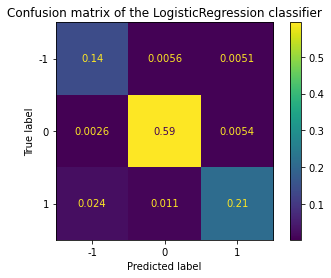

In [37]:
get_confusion_matrix(y_test,y_predicted,log_reg,id_model)

In [39]:
print(log_reg.score(X_train,y_train))
print(log_reg.score(X_test,y_test))

0.9526182009300553
0.9458544596561937
